In [1]:
import pickle
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sys
import re
import itertools
sys.path.insert(0, '/Users/lhao/Documents/Git/py_Halo-GEM/ecpy')

In [2]:
from curate_kcat_light_goslim_asc_step02 import *

In [3]:
results02 = pickle.load(open('../Results/smc_abc_light_step_02.pkl','rb'))

# Compare the mean kcat values. You can extract them directly from results.posterior. 
# or use results02.population.
#     data structure: [{((rxn_id,prot_id):kcat)}]*100. kcat is in the unit of 1/h
#     To calculate the mean in thel log10 space, firstly use np.mean(log10(x))

kcat_model = [item.loc for item in results02.posterior.values()] # those values are log10 transformed 1/h
kcat_model = [10**item/3600 for item in  kcat_model] # convert it to 1/s

In [4]:
# load prior, do not use results.prior, as it was not the real prior. forgot to use .copy in the very begining
model_one_pool_file = '../Results/template_ecModel_one_pool.pkl'
tmp_ecmodel = pickle.load(open(model_one_pool_file,'rb'))
df_enz_kcat = pd.read_csv('../Results/mapped_kcats_updated_with_ko.csv',index_col=0)

priors = build_priors(tmp_ecmodel,df_enz_kcat)

Using license file /Users/lhao/gurobi.lic
Academic license - for non-commercial use only
Read LP format model from file /var/folders/f_/qxjgggy53kgf53y_ytc_6nt1s_zp5x/T/tmprllvdj1l.lp
Reading time = 0.06 seconds
: 3834 rows, 9364 columns, 38948 nonzeros


In [5]:
kcat_model_prior = [item.loc for item in priors.values()] # those values are log10 transformed 1/h
kcat_model_prior = [10**item/3600 for item in  kcat_model_prior] # convert it to 1/s

In [6]:
kcatDB = pd.read_csv('../../../ComplementaryData/max_KCAT.txt',sep = '\t',header=None)
ecoli_kcat = kcatDB[kcatDB[2].str.contains('escherichia coli')][3].values
#bac_kcat = kcatDB[kcatDB[2].str.contains('bacteria')][3].values

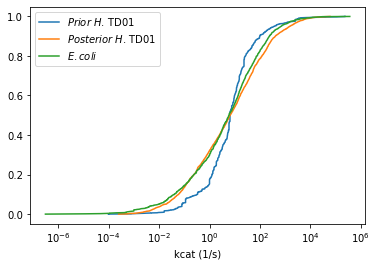

In [7]:
X_model = np.sort(kcat_model)
Y_model = np.array(range(len(X_model)))/float(len(X_model))

X_model_prior = np.sort(kcat_model_prior)
Y_model_prior = np.array(range(len(X_model_prior)))/float(len(X_model_prior))

X_ecoli = np.sort(ecoli_kcat)
Y_ecoli = np.array(range(len(X_ecoli)))/float(len(X_ecoli))

#X_bac = np.sort(bac_kcat)
#Y_bac = np.array(range(len(X_bac)))/float(len(X_bac))

#X_all = np.sort(kcatDB[3].values)
#Y_all = np.array(range(len(X_all)))/float(len(X_all))

plt.plot(X_model_prior  , Y_model_prior  ,label = '$Prior$ $H$. TD01')
plt.plot(X_model, Y_model,label = '$Posterior$ $H$. TD01') #
plt.plot(X_ecoli, Y_ecoli,label = '$E. coli$')

#plt.plot(X_all  , Y_all  ,label = 'All')

plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('kcat (1/s)')
plt.show()
plt.close()

### GoSlim
The file is `../proteomics/go-slim-in model.xlsx`

In [8]:
# loda table and get 'Genes' column
go_slim_db = pd.read_excel('../proteomics/go-slim-in model.xlsx', index_col=None, header=0)
go_slim_db['Genes'] = [list(set(i[4:])- {np.nan}) for i in go_slim_db.values.tolist()]  # remove np.nan
go_slim_db = go_slim_db[['Description', 'GoTerm', 'GeneNumber', 'Classification','Genes']]
go_slim_db.head()

,Description,GoTerm,GeneNumber,Classification,Genes
0,transmembrane transport,GO:0055085,67,metabolism,"[TD01GL001750, TD01GL001242, TD01GL001039, TD0..."
1,amino acid transport,GO:0006865,40,metabolism,"[TD01GL001240, TD01GL001663, TD01GL002902, TD0..."
2,carbohydrate metabolic process,GO:0005975,110,metabolism,"[TD01GL000554, TD01GL000536, TD01GL003062, TD0..."
3,carbohydrate transport,GO:0008643,15,metabolism,"[TD01GL002092, TD01GL001408, TD01GL000261, TD0..."
4,cellular amino acid metabolic process,GO:0006520,222,metabolism,"[TD01GL000483, TD01GL002451, TD01GL002723, TD0..."


In [9]:
# get 'Kcats' column for 'Genes' column
Gens_id_list = np.array([re.sub('(prot_)|(_(c|p|e))','',key[1]) for key in results02.posterior.keys()])
kcat_model = np.array(kcat_model)
kcat_model_prior = np.array(kcat_model_prior)

kcats_column = []
kcats_prior_column = []
for index in go_slim_db.index:
    genes_row = go_slim_db.iloc[index]['Genes']
    kcats_row = []
    kcats_prior_row = []
    for gene_i in genes_row:
        kcats_i = kcat_model[Gens_id_list == gene_i ]
        kcats_row.append(list(kcats_i))
        kcats_prior_i = kcat_model_prior[Gens_id_list == gene_i ]
        kcats_prior_row.append(list(kcats_prior_i))
    kcats_column.append(kcats_row)
    kcats_prior_column.append(kcats_prior_row)
go_slim_db['Kcats'] = kcats_column
go_slim_db['Kcats_prior'] = kcats_prior_column
go_slim_db.head()

,Description,GoTerm,GeneNumber,Classification,Genes,Kcats,Kcats_prior
0,transmembrane transport,GO:0055085,67,metabolism,"[TD01GL001750, TD01GL001242, TD01GL001039, TD0...","[[], [], [], [], [], [2.8432226472221043, 16.1...","[[], [], [], [], [], [5.922046751932458, 5.922..."
1,amino acid transport,GO:0006865,40,metabolism,"[TD01GL001240, TD01GL001663, TD01GL002902, TD0...","[[], [], [], [], [], [1.2442013573599617], [0....","[[], [], [], [], [], [6.456527653644495], [6.4..."
2,carbohydrate metabolic process,GO:0005975,110,metabolism,"[TD01GL000554, TD01GL000536, TD01GL003062, TD0...","[[91.15105916338727, 8687.688317058906, 15.918...","[[47.95310152263733, 47.95310152263733, 47.953..."
3,carbohydrate transport,GO:0008643,15,metabolism,"[TD01GL002092, TD01GL001408, TD01GL000261, TD0...","[[], [], [0.06285590555894949, 313.07905503502...","[[], [], [5.922046751932458, 6.456527653644495..."
4,cellular amino acid metabolic process,GO:0006520,222,metabolism,"[TD01GL000483, TD01GL002451, TD01GL002723, TD0...","[[2.657488471438235, 0.0054090797837926426, 0....","[[2.5685687022806345, 2.5685687022806345, 15.0..."


In [10]:
# TODO: some gens have no kcat such as TD01GL001757
kcats_i = kcat_model[Gens_id_list == 'TD01GL001757' ]
print(kcats_i)

[]


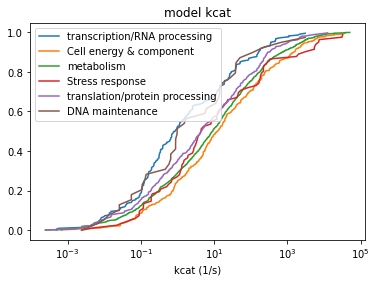

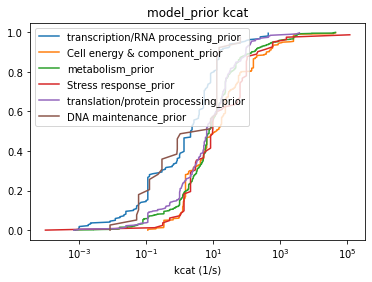

In [11]:
# plot for each classification
go_slim_db['Kcats_all'] = go_slim_db['Kcats'].apply(itertools.chain.from_iterable)  # convert to One-dimensional list
go_slim_db['Kcats_all'] = go_slim_db['Kcats_all'].apply(list)

go_slim_db['Kcats_prior_all'] = go_slim_db['Kcats_prior'].apply(itertools.chain.from_iterable)
go_slim_db['Kcats_prior_all'] = go_slim_db['Kcats_prior_all'].apply(list)

classifications = set(go_slim_db['Classification'])
for classification_i in classifications:
    kcat_i = go_slim_db[go_slim_db['Classification']==classification_i]['Kcats_all'].values
    kcat_i = list(itertools.chain.from_iterable(kcat_i))
    X_i = np.sort(kcat_i)
    Y_i= np.array(range(len(kcat_i)))/float(len(kcat_i))
    plt.plot(X_i  , Y_i  ,label = classification_i)
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('kcat (1/s)')
plt.title('model kcat')
plt.show()
plt.close()

# %%
# plot prior
for classification_i in classifications:
    kcat_prior_i = go_slim_db[go_slim_db['Classification']==classification_i]['Kcats_prior_all'].values
    kcat_prior_i = list(itertools.chain.from_iterable(kcat_prior_i))
    X_prior_i = np.sort(kcat_prior_i)
    Y_prior_i= np.array(range(len(kcat_prior_i)))/float(len(kcat_prior_i))
    plt.plot(X_prior_i  , Y_prior_i  ,label = classification_i + '_prior')
plt.xscale('log')
plt.legend(loc=0)
plt.xlabel('kcat (1/s)')
plt.title('model_prior kcat')
plt.show()
plt.close()



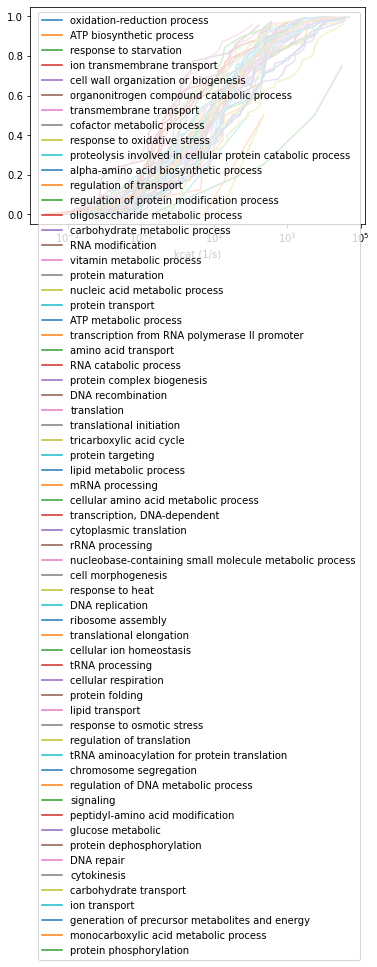

array([5.04254808e+00, 2.29832781e+00, 4.09587388e+02, ...,
       3.25945695e+01, 1.55004784e+00, 6.12946509e+03])

In [15]:
# descriptions = set(go_slim_db['Description'])
# for description_i in descriptions:
#     kcat_i = go_slim_db[go_slim_db['Description']==description_i]['Kcats_all'].values
#     kcat_i = list(itertools.chain.from_iterable(kcat_i))
#     X_i = np.sort(kcat_i)
#     Y_i= np.array(range(len(kcat_i)))/float(len(kcat_i))
#     plt.plot(X_i  , Y_i  ,label = description_i)
# plt.xscale('log')
# plt.legend(loc=0)
# plt.xlabel('kcat (1/s)')
# plt.show()
# plt.close()



In [13]:
kcatDB.head()

,0,1,2,3,4
0,EC1.1.1.1,(2e)-but-2-en-1-ol,yokenella sp.//*//*,101.0,*
1,EC1.1.1.1,(2e)-but-2-enal,yokenella sp.//*//*,405.0,*
2,EC1.1.1.1,(r)-1-indanol,sulfolobus acidocaldarius//prokaryotes;archaea...,7.1,*
3,EC1.1.1.1,(r)-2-butanol,equus caballus//eukaryotes;animals;vertebrates...,2.0,*
4,EC1.1.1.1,(r)-2-butanol,sulfolobus solfataricus//prokaryotes;archaea;c...,1.0,*


In [14]:
ecoli_kcat

array([3.00e-01, 5.90e-01, 1.35e+02, ..., 9.40e+00, 3.90e+00, 3.00e-02])